In [ ]:
# Link to Data: https://drive.google.com/drive/folders/1hnW0WihQj79rfboCA9cYTlSpuixWlnpM?usp=sharing
# Link to Colab Notebook: https://colab.research.google.com/drive/1XqXb8E1DuOtb71XP-bDAEwNnPUlLN82k?usp=sharing

In [ ]:
import os
import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.layers import * 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Constants
BATCH_SIZE = 32
NUM_CLASSES = 2
IMG_SIZE = 224
NUM_EPOCHS = 30
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

SEED = 1234
tf.random.set_seed(SEED)

FILE_DIR = "/content/gdrive/MyDrive/cxc/watonomous"

# Ignore Invalid Files

In [ ]:
classes = os.listdir(FILE_DIR)
filepaths = []
labels = []
acc_ext_list = ['jpg', 'jpeg', 'png']

for c in classes:
    c_path = os.path.join(FILE_DIR, c)
    print('processing class directory ', c)
    if os.path.isdir(c_path):
        file_list = os.listdir(c_path)
        for f in file_list:               
            f_path = os.path.join(c_path, f)
            index = f.rfind('.')
            ext = f[index+1:].lower()
            if ext not in acc_ext_list:
                print('file ', f_path, ' has an invalid extension ', ext)

            if os.path.isfile(f_path):
                try:
                    img=cv2.imread(f_path)
                    filepaths.append(f_path)
                    labels.append(c)
                except:
                    print('file ', f_path, ' is not a valid image file')
            else:
                print('*** fatal error, you have a sub directory ', f, ' in class directory ', c)
    else:
        print ('*** WARNING*** you have files in ', classes, ' it should only contain sub directories')

print('filepaths: ', len(filepaths), '    labels: ', len(labels))

processing class directory  NoLight
processing class directory  HasLight
filepaths:  129     labels:  129


# Create Dataframe of Images

In [ ]:
Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')

df = pd.concat([Fseries, Lseries], axis=1)
df = pd.DataFrame(np.array(df).reshape(len(filepaths),2), columns=['file_paths', 'labels'])

print(df['labels'].value_counts())

NoLight     66
HasLight    63
Name: labels, dtype: int64


# Visualize Images

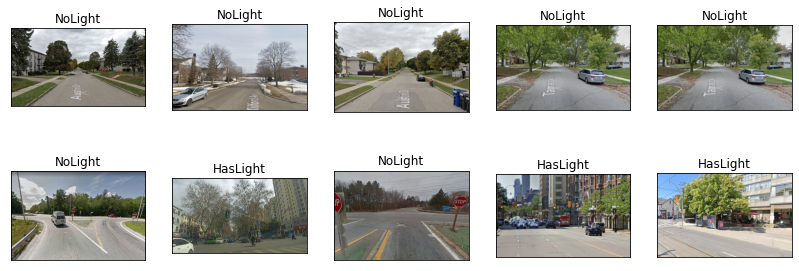

In [ ]:
plt.figure(figsize=(14,5))
for i in range(10):
  random = np.random.randint(1, len(df))
  plt.subplot(2,5,i+1)
  img = df.loc[random, 'file_paths']
  plt.imshow(plt.imread(img))
  plt.title(df.loc[random, 'labels'])
  plt.xticks([])
  plt.yticks([])

plt.show()


# Split Dataframe for Train and Validation

In [ ]:
train_df, test_df = train_test_split(df, 
                                     train_size=TRAIN_SIZE, 
                                     random_state=SEED)
train_df, valid_df = train_test_split(train_df, 
                                      train_size=TRAIN_SIZE, 
                                      random_state=SEED)

print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

NoLight     47
HasLight    35
Name: labels, dtype: int64
HasLight    13
NoLight      8
Name: labels, dtype: int64
HasLight    15
NoLight     11
Name: labels, dtype: int64


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    brightness_range=[0.6, 1.1],
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')
valid_gen = train_datagen.flow_from_dataframe(
    valid_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')
test_gen = train_datagen.flow_from_dataframe(
    test_df, 
    x_col='file_paths', y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary')


Found 82 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


# EfficientNetB3-based Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Defining Callback functions
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '/content/gdrive/MyDrive/cxc/watonomous_weights.h5', 
        save_best_only=True, 
        verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss',
        mode='min',
        verbose=1,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
3/3 [==============================] - 8s 3s/step - loss: 0.0634 - accuracy: 0.9634 - val_loss: 0.2693 - val_accuracy: 0.9048 - lr: 8.0000e-06
Epoch 2/30
3/3 [==============================] - 6s 2s/step - loss: 0.0836 - accuracy: 0.9756 - val_loss: 0.2508 - val_accuracy: 0.9048 - lr: 8.0000e-06
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 0.1451 - accuracy: 0.9634 - val_loss: 0.3391 - val_accuracy: 0.8571 - lr: 8.0000e-06
Epoch 4/30
3/3 [==============================] - 8s 3s/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9524 - lr: 8.0000e-06
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 0.0733 - accuracy: 0.9878 - val_loss: 0.3002 - val_accuracy: 0.8095 - lr: 8.0000e-06
Epoch 6/30
3/3 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9756
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.000000889296644e-07.
3/3 [==============================] - 5s 2s/step - loss: 0.05

In [ ]:
# Save model to directory (Saved on Google Drive)
model.save('/content/gdrive/MyDrive/cxc/saved_model/watonomous_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/cxc/saved_model/watonomous_model/assets


# Load Saved Model

In [ ]:
loaded_model = tf.keras.models.load_model('/saved_model/watonomous_model')

In [ ]:
loaded_model.evaluate(test_gen)

1/1 [==============================] - 4s 4s/step - loss: 0.1863 - accuracy: 0.9231


[0.1862804889678955, 0.9230769276618958]

# Predict Image using Saved Model

In [ ]:
img_path = filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.efficientnet.preprocess_input(x)

preds = loaded_model.predict(x)

np.rint(preds[0][0]) # 1: NoLight, 0: HasLight

1.0